In [1]:
import torch
import arcsim
from camera_ligh_model import Estimator

import os
from pytorch3d.io import load_objs_as_meshes, load_obj

from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex, SoftPhongShader
)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import img_as_ubyte

/home/ruben/anaconda3/envs/cloth-clone/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = "./real"
obj_filename = os.path.join(DATA_DIR, "S1/templates/template_mesh_final_textured.obj")
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

mesh = load_objs_as_meshes([obj_filename], device=device)

In [3]:
cameras = FoVPerspectiveCameras(device=device)

blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(0.0,0.0,0.0))

raster_settings = RasterizationSettings(
    image_size=(1080,1920), 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=50, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=(1080, 1920), 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0)))

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights, blend_params=blend_params)
)

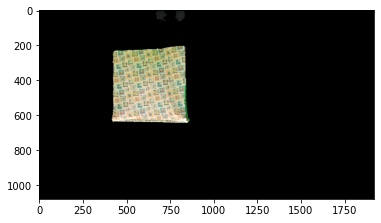

In [4]:
reference_path = os.path.join(DATA_DIR, "S1/templates/template_mesh_final_textured.png")
reference_image = plt.imread(reference_path)

plt.imshow(reference_image)

In [5]:
model = Estimator(meshes=mesh, renderer=silhouette_renderer, image_ref=reference_image).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [6]:
model.camera_position

Parameter containing:
tensor([0.0000, 0.0000, 2.5000], device='cuda:0', requires_grad=True)

In [7]:
loop = tqdm(range(200))
r = 0
t = 0
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 200:
        break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        
        plt.figure()
        plt.imshow(image)
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.axis("off")
    
    r = R
    t = T

print("R: {}, T: {}".format(R,T))
print("Model Camera Position: ", model.camera_position)

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 2.32 GiB (GPU 0; 9.78 GiB total capacity; 5.46 GiB already allocated; 803.19 MiB free; 5.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF